<a href="https://colab.research.google.com/github/bhewins1015/medigan/blob/main/rsna_spine_coor_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

from google.colab import drive
drive.mount('./gdrive')

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes
Mounted at ./gdrive


In [ ]:
!kaggle datasets download -d brendanartley/lumbar-coordinate-pretraining-dataset
!unzip -qq "/content/lumbar-coordinate-pretraining-dataset.zip"

Dataset URL: https://www.kaggle.com/datasets/brendanartley/lumbar-coordinate-pretraining-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 712M/717M [00:07<00:00, 70.5MB/s]
100% 717M/717M [00:07<00:00, 98.1MB/s]


In [ ]:
!pip install -q pytorch-lightning & pip install -q -U albumentations & pip install -q iterative-stratification
!pip install -q timm & pip install -q einops & pip install -q pytorch-lightning wandb & pip install torch-ema
!git clone https://github.com/mlpc-ucsd/CoaT
!pip install -q pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/53.8 kB ? eta -:--:--Requirement already satisfied: nvidia-nvjitlink-cu12 in /usr/local/lib/python3.10/dist-packages (from nvidia-cusolver-cu12==11.4.5.107->torch->torch-ema) (12.6.20)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
Cloning into 'CoaT'...
remote: Enumerating objects

In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger
import os
import yaml
import sys
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from glob import glob
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR, ReduceLROnPlateau
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
import torchvision.transforms as T
import albumentations as A
import pandas.api.types
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, StratifiedGroupKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
#from torchvision.models.maxvit import MaxVit
from timm.models.maxxvit import MaxxVit
import timm
import scipy
import albumentations as A
from torchvision.transforms import v2
from torchvision import models
from einops import repeat
from einops.layers.torch import Rearrange
from tqdm.auto import tqdm
sys.path.append('/content/CoaT')
from CoaT.src.models.coat import coat_lite_medium
from joblib import Parallel, delayed
from torch.utils.data import default_collate
from torch_ema import ExponentialMovingAverage
import pydicom as dcm
import transformers
from PIL import Image, ImageFilter

/content/CoaT/src/models/coat.py:589: UserWarning: Overwriting coat_tiny in registry with CoaT.src.models.coat.coat_tiny. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def coat_tiny(**kwargs):
/content/CoaT/src/models/coat.py:595: UserWarning: Overwriting coat_mini in registry with CoaT.src.models.coat.coat_mini. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def coat_mini(**kwargs):
/content/CoaT/src/models/coat.py:601: UserWarning: Overwriting coat_small in registry with CoaT.src.models.coat.coat_small. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def coat_small(**kwargs):
/content/CoaT/src/models/coat.py:608: UserWarning: Overwriting coat_lite_tiny in registry with CoaT.src.models.coat.coat_lite_tiny. This is because the name being registered conflicts with an existing name. Plea

In [ ]:
SEED = 126 # friend's birthday
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # Fix the network according to random seed
    print('Finish seeding with seed {}'.format(seed))

seed_everything(SEED)
print('Training on device {}'.format(device))

Finish seeding with seed 126
Training on device cuda


In [ ]:
%%writefile config.yaml

data_path: "/content/"
output_dir: "/content/gdrive/MyDrive/RSNA_SPINE/models/"

seed: 1101

train_bs: 4
valid_bs: 4
workers: 1

progress_bar_refresh_rate: 1

pseudo_train: 0

save_topk: 1
fold: 5

task:
    #kind: 'detect'
    kind: 'classify'
    #kind: 'depth'
    #condition: 'nfn'
    condition: 'scs'
    #condition: 'ss'
    #condition: 'all'
    #direction: 'sagt1'
    direction: 'ax'
    #direction: 'sagt1'
    position:
        - 'L1/L2'
        - 'L2/L3'
        - 'L3/L4'
        - 'L4/L5'
        - 'L5/S1'

in_chans: 3

image_size: 384
early_stop:
    monitor: "val_loss"
    mode: "min"
    patience: 999
    verbose: 1

trainer:
    max_epochs: 25
    min_epochs: 25
    enable_progress_bar: True
    precision: "16-mixed"
    devices: 1

model:
    name: "eff"
    loss_smooth: 0.0
    optimizer_params:
        lr: 0.0001
        #lr: 0.001
        weight_decay: 0.0001
    scheduler:
        name: "CosineAnnealingLR"
        #name: "ReduceLROnPlateau"
        #name: "cosine_with_warmup"
        #name: "ChrisLR"
        params:
            CosineAnnealingLR:
                T_max: 25
                eta_min: 5.0e-5
                last_epoch: -1
            ReduceLROnPlateau:
                mode: "min"
                factor: 0.5
                patience: 2
                min_lr: 0.00001
                verbose: True
            ChrisLR:
                freeze_iter: 2
            cosine_with_warmup:
                num_training_steps: 25
                num_warmup_steps: 2
                num_cycles: 0.5
                last_epoch: -1


Overwriting config.yaml


In [ ]:
with open("config.yaml", "r") as file_obj:
    config = yaml.safe_load(file_obj)

In [ ]:
coor = pd.read_csv('/content/coords_pretrain.csv')
coor.head(3)

,filename,source,x,y,level,relative_x,relative_y
0,1_t2.jpg,spider,139,175,L5/S1,0.542969,0.683594
1,1_t2.jpg,spider,133,157,L4/L5,0.519531,0.613281
2,1_t2.jpg,spider,132,131,L3/L4,0.515625,0.511719


In [ ]:
coor.groupby(['filename']).count()['x'].describe()
# 全部の画像にL1~S1まである

,x
count,1121.0
mean,5.0
std,0.0
min,5.0
25%,5.0
50%,5.0
75%,5.0
max,5.0


(256, 256)

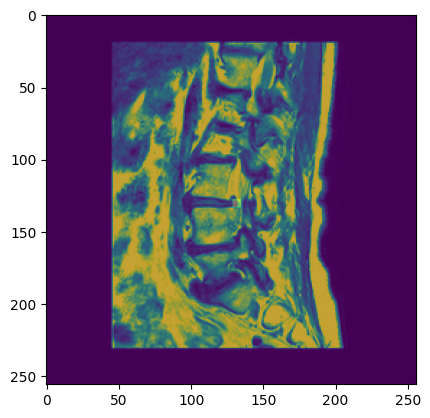

In [ ]:
source='spider'
name='1_t2.jpg'
path = f'/content/data/processed_{source}_jpgs/{name}'
img = np.array(Image.open(path))
plt.imshow(img)
x = 0.515625
y = 0.511719
y = img.shape[0]*y
x = img.shape[1]*x
mask = np.zeros(img.shape)
mask[int(y-3):int(y+3), int(x-3):int(x+3)] = 1
plt.imshow(mask, alpha=0.3)
img.shape

In [ ]:
class CoorDetectDataset(Dataset):
    def __init__(self, coor):
        self.coor = coor
        self.path = []
        for _, row in self.coor.iterrows():
            self.path.append(f'/content/data/processed_{row.source}_jpgs/{row.filename}')
        self.resize = v2.Resize((384, 384))

    def __getitem__(self, index):
        path = self.path[index]
        img = np.array(Image.open(path))
        img = img.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min())
        img = self.resize(torch.from_numpy(img)[None, ...])
        img = img.repeat(3, 1, 1)
        filename = path.split('/')[-1]
        sub_coor = self.coor.loc[self.coor.filename==filename]
        coor_dict = {}
        for _, row in sub_coor.iterrows():
            coor_dict[row.level] = torch.tensor([row.relative_x, row.relative_y])
        return img, coor_dict, path

    def __len__(self):
        return len(self.path)

In [ ]:
dataset = CoorDetectDataset(coor)
dataset[0][2]

'/content/data/processed_spider_jpgs/1_t2.jpg'

In [ ]:
class ConvNextSCSDetect(nn.Module):
    def __init__(self):
        super().__init__()
        #self.size = 384
        self.encoder = timm.create_model('tf_efficientnetv2_l.in21k_ft_in1k', in_chans=3, pretrained=True, num_classes=0, drop_rate=0.)
        self.in_features = self.encoder.num_features
        self.flatten = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                    nn.Flatten(1),
                                    )

        self.l1 = nn.Linear(self.in_features, 2)
        self.l2 = nn.Linear(self.in_features, 2)
        self.l3 = nn.Linear(self.in_features, 2)
        self.l4 = nn.Linear(self.in_features, 2)
        self.l5 = nn.Linear(self.in_features, 2)
        #self.out = nn.Linear(self.in_features, 10)
    def forward(self, x, label=None):
        x = self.encoder.forward_features(x)
        x = self.flatten(x)
        l1 = self.l1(x)
        l2 = self.l2(x)
        l3 = self.l3(x)
        l4 = self.l4(x)
        l5 = self.l5(x)
        return {'L1/L2': l1.sigmoid(), 'L2/L3': l2.sigmoid(), 'L3/L4': l3.sigmoid(), 'L4/L5': l4.sigmoid(), 'L5/S1': l5.sigmoid()}


In [ ]:
class SCSDetectLoss(nn.Module):
    def __init__(self):
        super(SCSDetectLoss, self).__init__()

    def forward(self, outputs, targets):
        loss = 0
        for level in ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']:
            _loss = nn.functional.l1_loss(outputs[level], targets[level])
            loss += _loss
        return loss/5

class SCSDetectRelativePositionLoss(nn.Module):
    def __init__(self):
        super(SCSDetectRelativePositionLoss, self).__init__()

    def forward(self, outputs, targets):
        loss = 0
        for level in ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']:
            _loss = nn.functional.l1_loss(outputs[level], targets[level])
            loss += _loss
        loss/5
        relative_positional_loss = 0
        for l in ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']:
            relative_positional_pred_list = []
            relative_positional_tar_list = []
            for ll in ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']:
                if l == ll:
                    continue
                pred1, pred2 = outputs[l], outputs[ll]
                tar1, tar2 = targets[l], targets[ll]
                dist_pred = torch.sqrt((pred1[:, 0]-pred2[:, 0])**2 + (pred1[:, 1]-pred2[:, 1])**2)
                dist_tar = torch.sqrt((tar1[:, 0]-tar2[:, 0])**2 + (tar1[:, 1]-tar2[:, 1])**2)
                relative_positional_pred_list.append(dist_pred)
                relative_positional_tar_list.append(dist_tar)
            relative_positional_pred = torch.cat(relative_positional_pred_list)
            relative_positional_tar = torch.cat(relative_positional_tar_list)
            relative_positional_loss += nn.functional.l1_loss(relative_positional_pred, relative_positional_tar)
        return loss/5 + relative_positional_loss/5

In [ ]:
class DetectModule(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = ConvNextSCSDetect()
        #self.model = SwinSCSDetect()
        #self.loss_module = SCSDetectRelativePositionLoss()
        self.loss_module = SCSDetectLoss()
        self.val_step_outputs = []
        self.val_step_labels = []
        #self.ema = ExponentialMovingAverage(self.model.parameters(), decay=0.995)
        #self.ema.to(device)

        #self.model = torch.optim.swa_utils.AveragedModel(self.model,
        #                                                 multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(0.999))

    def forward(self, batch):
        preds = self.model(batch)
        return preds

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config['model']["optimizer_params"])
        if self.config['model']["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config['model']["scheduler"]["params"]["CosineAnnealingLR"],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config['model']["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config['model']["scheduler"]["params"]["ReduceLROnPlateau"],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}
        elif self.config['model']['scheduler']['name'] == 'ChrisLR':
            scheduler = ChrisLR(
                optimizer,
                **self.config['model']["scheduler"]["params"]["ChrisLR"],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}
        elif self.config['model']['scheduler']['name'] == 'cosine_with_warmup':
            print('cosine with warmup')
            print(self.config['model']['scheduler']['params']['cosine_with_warmup'])
            scheduler = transformers.get_cosine_schedule_with_warmup(
                optimizer,
                **self.config['model']['scheduler']['params']['cosine_with_warmup'],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        else:
            return {"optimizer": optimizer}

    def training_step(self, batch, batch_idx):
        imgs, label, _ = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, label)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=config['train_bs'])
        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """Add TTA"""
        volume, label, _ = batch
        preds = self.model.forward(volume)
        loss = self.loss_module(preds, label)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}", flush=True)
        return 0

    def optimizer_step(self, *args, **kwargs):
        super().optimizer_step(*args, **kwargs)
        #self.ema.update()

In [ ]:
train, valid = train_test_split(coor.filename.unique(), test_size=0.2, random_state=42)
train_coor = coor.loc[coor.filename.isin(train)]
valid_coor = coor.loc[coor.filename.isin(valid)]

In [ ]:
train_coor.shape, valid_coor.shape

((4480, 7), (1125, 7))

In [ ]:
T_MAX = config["model"]["scheduler"]["params"]["CosineAnnealingLR"]["T_max"]
num_training_steps = config["model"]["scheduler"]["params"]["cosine_with_warmup"]["num_training_steps"]
num_warmup_steps = config["model"]["scheduler"]["params"]["cosine_with_warmup"]["num_warmup_steps"]

In [ ]:
%%time
import warnings
warnings.filterwarnings("ignore")
##############COORDINATE DETECT#########################

print(T_MAX)
#for i in [5]:
for i in [0]:
    dataset_train = CoorDetectDataset(train_coor)
    dataset_validation = CoorDetectDataset(valid_coor)

    data_loader_train = DataLoader(
        dataset_train,
        batch_size=4,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    data_loader_validation = DataLoader(
        dataset_validation,
        batch_size=8,
        shuffle=False,
        num_workers=8,
        pin_memory=True
    )

    checkpoint_callback = ModelCheckpoint(
        save_weights_only=True,
        monitor="val_loss",
        dirpath="/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models",
        mode='min',
        filename=f"scs_detect_pretrained_efficientnetv2l_1e-4",
        save_top_k=config["save_topk"],
        verbose=1,
    )

    progress_bar_callback = TQDMProgressBar(
        refresh_rate=config["progress_bar_refresh_rate"]
    )

    early_stop_callback = EarlyStopping(**config["early_stop"])
    _c, _k = config['task']['condition'], config['task']['kind']
    wandb_logger = WandbLogger(project=f'rsna_spine_coor_pretrained', # group runs in "MNIST" project
                            log_model=False) # log all new checkpoints during training

    trainer = pl.Trainer(
        logger=wandb_logger,
        callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback],
        **config["trainer"],
    )

    config["model"]["scheduler"]["params"]["CosineAnnealingLR"]["T_max"] = T_MAX*len(data_loader_train)/config["trainer"]["devices"]
    config["model"]["scheduler"]["params"]["cosine_with_warmup"]["num_training_steps"] = int(num_training_steps*len(data_loader_train)/config["trainer"]["devices"])
    config["model"]["scheduler"]["params"]["cosine_with_warmup"]["num_warmup_steps"] = int(num_warmup_steps*len(data_loader_train)/config["trainer"]["devices"])
    model = DetectModule(config=config)
    trainer.fit(model, data_loader_train, data_loader_validation)
    wandb.finish()

25


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


model.safetensors:   0%|          | 0.00/476M [00:00<?, ?B/s]

wandb: Currently logged in as: syujinko. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | ConvNextSCSDetect | 117 M  | train
1 | loss_module | SCSDetectLoss     | 0      | train
----------------------------------------------------------
117 M     Trainable params
0         Non-trainable params
117 M     Total params
468.988   Total estimated model params size (MB)
1447      Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Epoch: 0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 0


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.012
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1120: 'val_loss' reached 0.01183 (best 0.01183), saving model to '/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models/scs_detect_pretrained_efficientnetv2l_1e-4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 1


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.009
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2240: 'val_loss' reached 0.00893 (best 0.00893), saving model to '/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models/scs_detect_pretrained_efficientnetv2l_1e-4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 2


INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 3360: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 3


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.008
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 4480: 'val_loss' reached 0.00769 (best 0.00769), saving model to '/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models/scs_detect_pretrained_efficientnetv2l_1e-4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 4


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 5600: 'val_loss' reached 0.00726 (best 0.00726), saving model to '/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models/scs_detect_pretrained_efficientnetv2l_1e-4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 5


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 6720: 'val_loss' reached 0.00678 (best 0.00678), saving model to '/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models/scs_detect_pretrained_efficientnetv2l_1e-4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 6


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 7840: 'val_loss' reached 0.00641 (best 0.00641), saving model to '/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models/scs_detect_pretrained_efficientnetv2l_1e-4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 7


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 8960: 'val_loss' reached 0.00612 (best 0.00612), saving model to '/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models/scs_detect_pretrained_efficientnetv2l_1e-4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 8


INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 10080: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 9


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 11200: 'val_loss' reached 0.00581 (best 0.00581), saving model to '/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models/scs_detect_pretrained_efficientnetv2l_1e-4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 10


INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 12320: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 11


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 13440: 'val_loss' reached 0.00539 (best 0.00539), saving model to '/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models/scs_detect_pretrained_efficientnetv2l_1e-4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 12


INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 14560: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 13


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 15680: 'val_loss' reached 0.00513 (best 0.00513), saving model to '/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models/scs_detect_pretrained_efficientnetv2l_1e-4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 14


INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 16800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 15


INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 17920: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 16


INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 19040: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 17


INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 20160: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 18


INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 21280: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 19


INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 22400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 20


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 23520: 'val_loss' reached 0.00504 (best 0.00504), saving model to '/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models/scs_detect_pretrained_efficientnetv2l_1e-4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 21


INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 24640: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 22


INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 25760: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 23


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 26880: 'val_loss' reached 0.00504 (best 0.00504), saving model to '/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models/scs_detect_pretrained_efficientnetv2l_1e-4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch: 24


INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 28000: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train_loss_epoch,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▆▅▃▃▃▂▅▃▂▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▆▄▃▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
epoch,24
lr,5e-05
train_loss_epoch,0.0015
train_loss_step,0.00166
trainer/global_step,27999


CPU times: user 2h 16min 52s, sys: 4min 30s, total: 2h 21min 22s
Wall time: 2h 34min 22s


In [ ]:
dataset_validation = CoorDetectDataset(valid_coor)
data_loader = DataLoader(
        dataset_validation,
        batch_size=8,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )

# prediction
model = DetectModule.load_from_checkpoint(checkpoint_path='/content/gdrive/MyDrive/RSNA_SPINE/pretrained_models/scs_detect_pretrained_convnext-base.ckpt', config=config)
model.eval()
model.zero_grad()
model.to(device)
coor_predict = {'L1/L2': [], 'L2/L3': [], 'L3/L4': [], 'L4/L5': [], 'L5/S1': []}
coor_label = {'L1/L2': [], 'L2/L3': [], 'L3/L4': [], 'L4/L5': [], 'L5/S1': []}
path_list = []
with torch.no_grad():
    for data in tqdm(data_loader, total=len(data_loader)):
        images, label, path = data
        path_list.append(path)
        images = images.to(device)
        preds = model.forward(images)
        #print(preds)
        for k, v in preds.items():
            coor_predict[k].append(v.to('cpu').detach().numpy())
        for k, v in label.items():
            coor_label[k].append(v.detach().numpy())



  0%|          | 0/141 [00:00<?, ?it/s]

In [ ]:
for k, v in coor_predict.items():
    coor_predict[k] = np.concatenate(v)
for k, v in coor_label.items():
    coor_label[k] = np.concatenate(v)
path_list = np.concatenate(path_list)

In [ ]:
coor_label['L5/S1'][0]

array([0.47265625, 0.73046875], dtype=float32)

In [ ]:
path_list[0]

'/content/data/processed_lsd_jpgs/0042.jpg'

In [ ]:
valid_coor.loc[valid_coor.filename=='0042.jpg']

,filename,source,x,y,level,relative_x,relative_y
1235,0042.jpg,lsd,121,187,L5/S1,0.472656,0.730469
1236,0042.jpg,lsd,109,164,L4/L5,0.425781,0.640625
1237,0042.jpg,lsd,107,135,L3/L4,0.417969,0.527344
1238,0042.jpg,lsd,111,103,L2/L3,0.433594,0.402344
1239,0042.jpg,lsd,117,71,L1/L2,0.457031,0.277344


In [ ]:
df_list = []
for k, v in coor_predict.items():
    df = pd.DataFrame(v, columns=['p_x', 'p_y'])
    df['filename'] = [p.split('/')[-1] for p in path_list]
    df['path'] = path_list
    df['level'] = k
    df_list.append(df)
df = pd.concat(df_list)
df

,p_x,p_y,filename,path,level
0,0.485187,0.295690,0042.jpg,/content/data/processed_lsd_jpgs/0042.jpg,L1/L2
1,0.526027,0.320308,case_0165.jpg,/content/data/processed_tseg_jpgs/case_0165.jpg,L1/L2
2,0.594638,0.280516,0155.jpg,/content/data/processed_lsd_jpgs/0155.jpg,L1/L2
3,0.587587,0.370527,123_t2.jpg,/content/data/processed_spider_jpgs/123_t2.jpg,L1/L2
4,0.524223,0.320678,case_0303.jpg,/content/data/processed_tseg_jpgs/case_0303.jpg,L1/L2
...,...,...,...,...,...
1120,0.471292,0.712154,0537.jpg,/content/data/processed_lsd_jpgs/0537.jpg,L5/S1
1121,0.471224,0.725936,0131.jpg,/content/data/processed_lsd_jpgs/0131.jpg,L5/S1
1122,0.491490,0.709699,0371.jpg,/content/data/processed_lsd_jpgs/0371.jpg,L5/S1
1123,0.498009,0.768342,case_0254.jpg,/content/data/processed_tseg_jpgs/case_0254.jpg,L5/S1


In [ ]:
valid_coor = valid_coor.merge(df, on=['filename', 'level'], how='left')

In [ ]:
valid_coor['x_diff'] = (valid_coor['p_x'] - valid_coor['relative_x']).abs()
valid_coor['y_diff'] = (valid_coor['p_y'] - valid_coor['relative_y']).abs()
valid_coor.sort_values('y_diff', ascending=False).head(10)

,filename,source,x,y,level,relative_x,relative_y,p_x,p_y,path,x_diff,y_diff
3397,0472.jpg,lsd,97,70,L1/L2,0.378906,0.273438,0.578226,0.419533,/content/data/processed_lsd_jpgs/0472.jpg,0.199320,0.146095
3398,0472.jpg,lsd,97,70,L1/L2,0.378906,0.273438,0.578226,0.419533,/content/data/processed_lsd_jpgs/0472.jpg,0.199320,0.146095
3395,0472.jpg,lsd,97,70,L1/L2,0.378906,0.273438,0.578226,0.419533,/content/data/processed_lsd_jpgs/0472.jpg,0.199320,0.146095
3399,0472.jpg,lsd,97,70,L1/L2,0.378906,0.273438,0.578226,0.419533,/content/data/processed_lsd_jpgs/0472.jpg,0.199320,0.146095
3396,0472.jpg,lsd,97,70,L1/L2,0.378906,0.273438,0.578226,0.419533,/content/data/processed_lsd_jpgs/0472.jpg,0.199320,0.146095
824,173_t2.jpg,spider,167,49,L1/L2,0.652344,0.191406,0.649470,0.336726,/content/data/processed_spider_jpgs/173_t2.jpg,0.002874,0.145320
820,173_t2.jpg,spider,167,49,L1/L2,0.652344,0.191406,0.649470,0.336726,/content/data/processed_spider_jpgs/173_t2.jpg,0.002874,0.145320
821,173_t2.jpg,spider,167,49,L1/L2,0.652344,0.191406,0.649470,0.336726,/content/data/processed_spider_jpgs/173_t2.jpg,0.002874,0.145320
823,173_t2.jpg,spider,167,49,L1/L2,0.652344,0.191406,0.649470,0.336726,/content/data/processed_spider_jpgs/173_t2.jpg,0.002874,0.145320
822,173_t2.jpg,spider,167,49,L1/L2,0.652344,0.191406,0.649470,0.336726,/content/data/processed_spider_jpgs/173_t2.jpg,0.002874,0.145320


(256, 256)

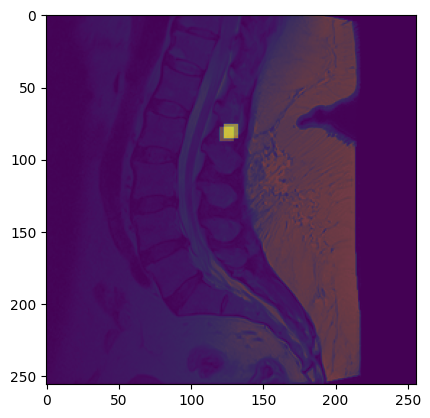

In [ ]:
num = 16
#path = path_list[num]
path = "/content/data/processed_lsd_jpgs/0472.jpg"
img = np.array(Image.open(path))
plt.imshow(img)
px = coor_predict['L1/L2'][num][0]*img.shape[1]
py = coor_predict['L1/L2'][num][1]*img.shape[0]
x = coor_label['L1/L2'][num][0]*img.shape[1]
y = coor_label['L1/L2'][num][1]*img.shape[0]

mask = np.zeros(img.shape)
mask[int(y-5):int(y+5), int(x-5):int(x+5)] = 1
pred_mask = np.zeros(img.shape)
pred_mask[int(py-5):int(py+5), int(px-5):int(px+5)] = 1
plt.imshow(mask, alpha=0.5)
plt.imshow(pred_mask, alpha=0.5)
img.shape